In [1]:
from model import uniformer_small

/mnt/petrelfs/likunchang/.conda/envs/video/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import OrderedDict

import os
import cv2
import torch
import torchvision
import torch.nn
import torch.nn.functional as F
import argparse
import numpy as np
from PIL import Image
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from decord import VideoReader
from decord import cpu

In [3]:
import random
import pickle

In [4]:
state_dict = torch.load('/mnt/petrelfs/likunchang/model/uniformer_small_k400_16x8.pth', map_location='cpu')

In [5]:
model = uniformer_small()
model.load_state_dict(state_dict)
model.eval()

Uniformer(
  (patch_embed1): SpeicalPatchEmbed(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (proj): Conv3d(3, 64, kernel_size=(3, 4, 4), stride=(2, 4, 4), padding=(1, 0, 0))
  )
  (patch_embed2): PatchEmbed(
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (proj): Conv3d(64, 128, kernel_size=(1, 2, 2), stride=(1, 2, 2))
  )
  (patch_embed3): PatchEmbed(
    (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    (proj): Conv3d(128, 320, kernel_size=(1, 2, 2), stride=(1, 2, 2))
  )
  (patch_embed4): PatchEmbed(
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (proj): Conv3d(320, 512, kernel_size=(1, 2, 2), stride=(1, 2, 2))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks1): ModuleList(
    (0): CBlock(
      (pos_embed): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=64)
      (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
from transforms import (
    GroupNormalize, GroupScale, GroupCenterCrop, 
    Stack, ToTorchFormatTensor
)

In [7]:
# load image
crop_size = 448
scale_size = 512
input_mean = [0.485, 0.456, 0.406]
input_std = [0.229, 0.224, 0.225]

input_mean2 = [0.5, 0.5, 0.5]
input_std2 = [0.5, 0.5, 0.5]

transform1 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack(),
    ToTorchFormatTensor(),
    GroupNormalize(input_mean, input_std),
])

transform2 = torchvision.transforms.Compose([
    GroupScale(int(scale_size)),
    GroupCenterCrop(crop_size),
    Stack(),
])

/mnt/petrelfs/likunchang/.conda/envs/video/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
def get_index(num_frames, num_segments, dense_sample_rate=8, method='dense'):
    if method == 'dense':
        sample_range = num_segments * dense_sample_rate
        sample_pos = max(1, 1 + num_frames - sample_range)
        t_stride = dense_sample_rate
        start_idx = 0 if sample_pos == 1 else sample_pos // 2
        offsets = np.array([
            (idx * t_stride + start_idx) %
            num_frames for idx in range(num_segments)
        ])
    else:
        if num_frames > num_segments:
            tick = num_frames / float(num_segments)
            offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)])
        else:
            offsets = np.zeros((num_segments,))
    return offsets

In [9]:
def load_images(video, selected_frames, transform1, transform2):
    t_size = len(selected_frames)
    images = np.zeros((t_size, crop_size, crop_size, 3))
    orig_imgs = np.zeros_like(images)
    images_group = list()
    for i, frame_index in enumerate(selected_frames):
        img = Image.fromarray(video[frame_index].asnumpy())
        images_group.append(img)
        r_image = np.array(img)[:,:,::-1]
        orig_imgs[i] = transform2([Image.fromarray(r_image)])  
    torch_imgs = transform1(images_group)
    return np.expand_dims(orig_imgs, 0), torch_imgs

In [10]:
label_file = '../data_list/k400/kinetics_400_categroies.txt'
category = []
for x in open(label_file):
    category.append(x.rstrip().split('\t')[0])
num_class = len(category)

In [11]:
train_list = list()
with open('../data_list/k400/val.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.rstrip()
        train_list.append(line.split(','))

In [12]:
path_prefix = './example_video' 
# set this path for your own data
# we only put one example video from Kinetics-400
def get_img(index, length=16):
    path, label = train_list[index]
    video_path = os.path.join(path_prefix, path)
    vr = VideoReader(video_path, ctx=cpu(0))
    num_frames = len(vr)
    frame_indices = get_index(num_frames, length, dense_sample_rate=32)
    RGB_vid, vid = load_images(vr, frame_indices, transform1, transform2)
    
    return RGB_vid, vid, path, int(label)

In [13]:
def show_img(index):
    RGB_vid, vid, path, label = get_img(index)
    
    TC, H, W = vid.shape
    inputs = vid.reshape(1, TC//3, 3, H, W).permute(0, 2, 1, 3, 4)
    with torch.no_grad():
        pred, y = model(inputs)
        pred = torch.argmax(pred).item()
    
    print("path: {}".format(path))
    print("ground truth: {}-{}".format(label, category[label]))
    print("prediction: {}-{}".format(pred, category[pred]))

    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 200 #分辨率
    plt.figure(figsize=(16, 4))
    gs=gridspec.GridSpec(2,8,wspace=0.0, hspace=0.0)
    for i in range(2):
        for j in range(8):
            plt.subplot(gs[i,j])
            temp = RGB_vid[0][i*8+j]
            plt.imshow(temp[:,:,::-1]/255.)
            plt.axis('off')
    plt.show()

    # for i in range(16):
    #     temp = RGB_vid[0][i]
    #     plt.imshow(temp[:,:,::-1]/255.)
    #     plt.axis('off')
    #     plt.savefig(f'./fea/{i}.png', bbox_inches='tight', dpi=300)
    #     plt.show()

path: Tw2yXa6CzWE.mp4
ground truth: 370-yoga
prediction: 370-yoga


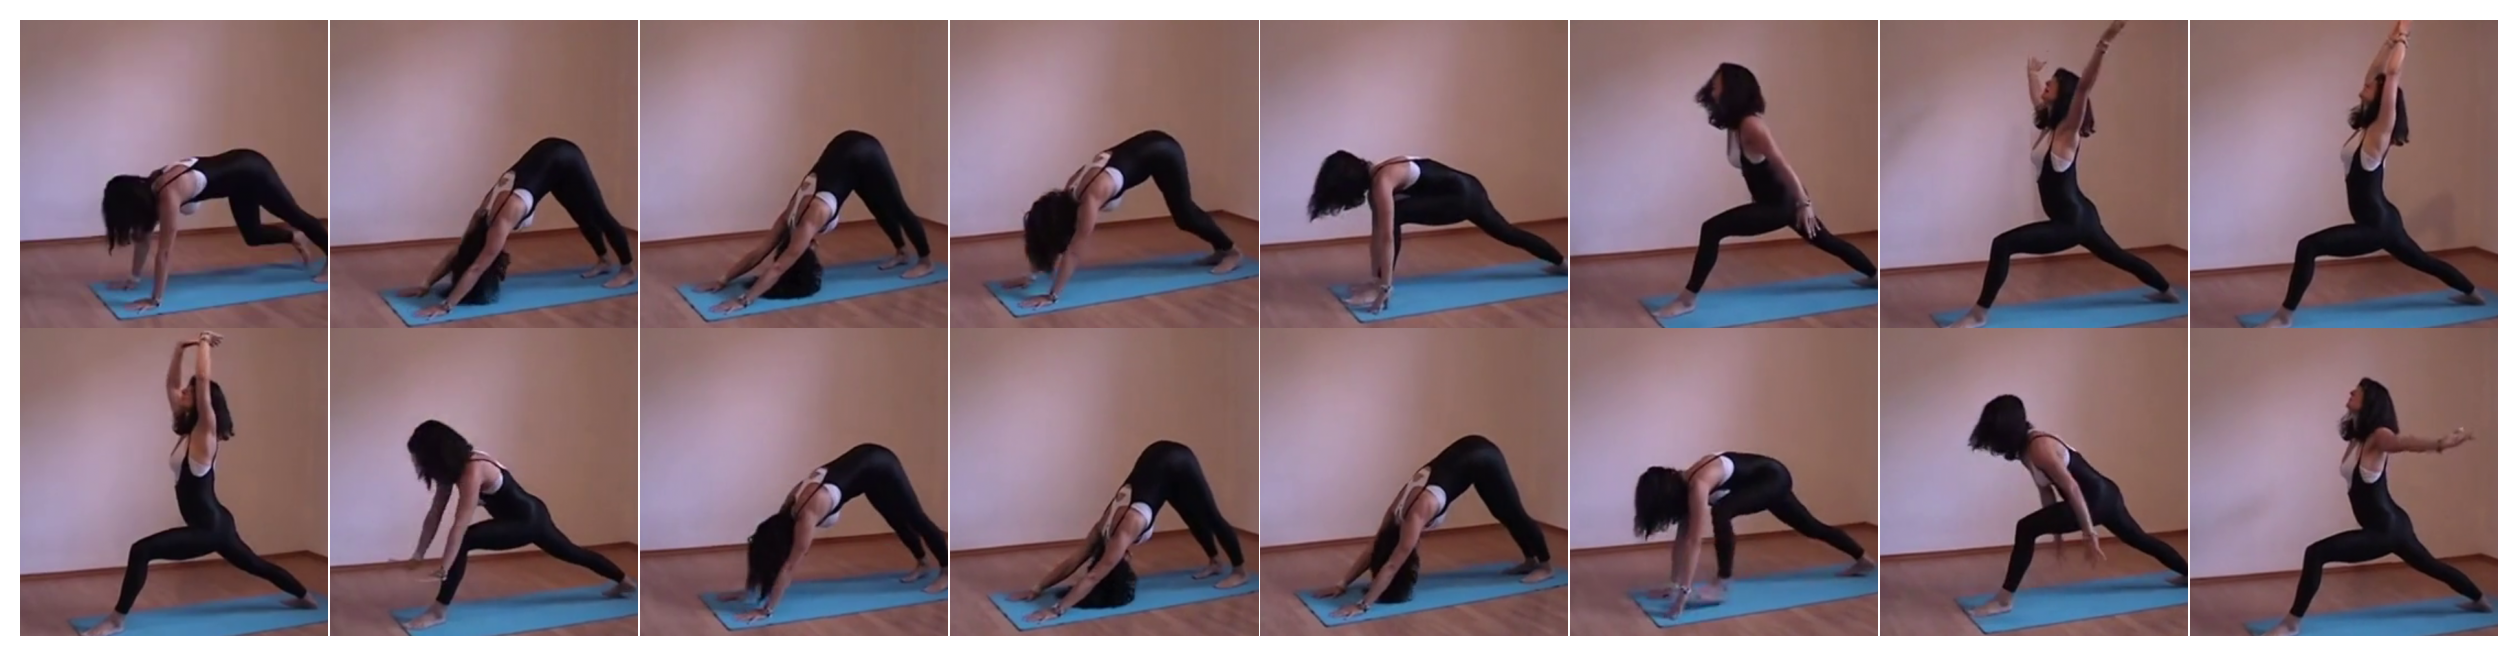

In [14]:
show_img(19745)

In [15]:
from matplotlib.colors import CenteredNorm 
def show_fea(index):
    RGB_vid, vid, path, label = get_img(index, length=16)

    TC, H, W = vid.shape
    inputs = vid.reshape(1, TC//3, 3, H, W).permute(0, 2, 1, 3, 4)
    with torch.no_grad():
        pred, y = model(inputs)
        pred = torch.argmax(pred).item()
        
    print("path: {}".format(path))
    print("ground truth: {}-{}".format(label, category[label]))
    print("prediction: {}-{}".format(pred, category[pred]))
        
    plt.rcParams['savefig.dpi'] = 200 #图片像素
    plt.rcParams['figure.dpi'] = 200 #分辨率
    # length = len(y)
    # plt.figure(figsize=(8, length+2))
    # gs=gridspec.GridSpec(length, 8)
    # for i in range(length):
    length = 4
    plt.figure(figsize=(8, length+1))
    gs=gridspec.GridSpec(length, 8)
    depth_list = [2, 6, 14, 17] # UniFormer-S [3, 4, 8, 3]
    for i in range(len(depth_list)):
        d_idx = depth_list[i]
        show_fea = y[d_idx]
        B, C, T, H, W = show_fea.shape
        show_fea = show_fea[0].view(C, T, H, W).permute(1, 2, 3, 0)
        for j in range(8):
            plt.subplot(gs[i,j])
            tmp_fea = -show_fea[j].mean(-1)
            print(tmp_fea.shape)
            plt.imshow(tmp_fea, norm=CenteredNorm(vcenter=tmp_fea.mean()))

            plt.title(f'l_{i}-t_{j}', fontsize=6)
            plt.axis('off')
        
        # for j in range(8):
        #     tmp_fea = -show_fea[j].mean(-1)
        #     plt.imshow(tmp_fea, norm=CenteredNorm(vcenter=tmp_fea.mean()))
        #     # plt.imshow(-show_fea[j].mean(-1))
        #     plt.axis('off')
        #     plt.savefig(f'./fea/{i}_{j}.png', bbox_inches='tight', dpi=300)
        #     plt.show()

path: Tw2yXa6CzWE.mp4
ground truth: 370-yoga
prediction: 370-yoga
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([112, 112])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([56, 56])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])
torch.Size([14, 14])


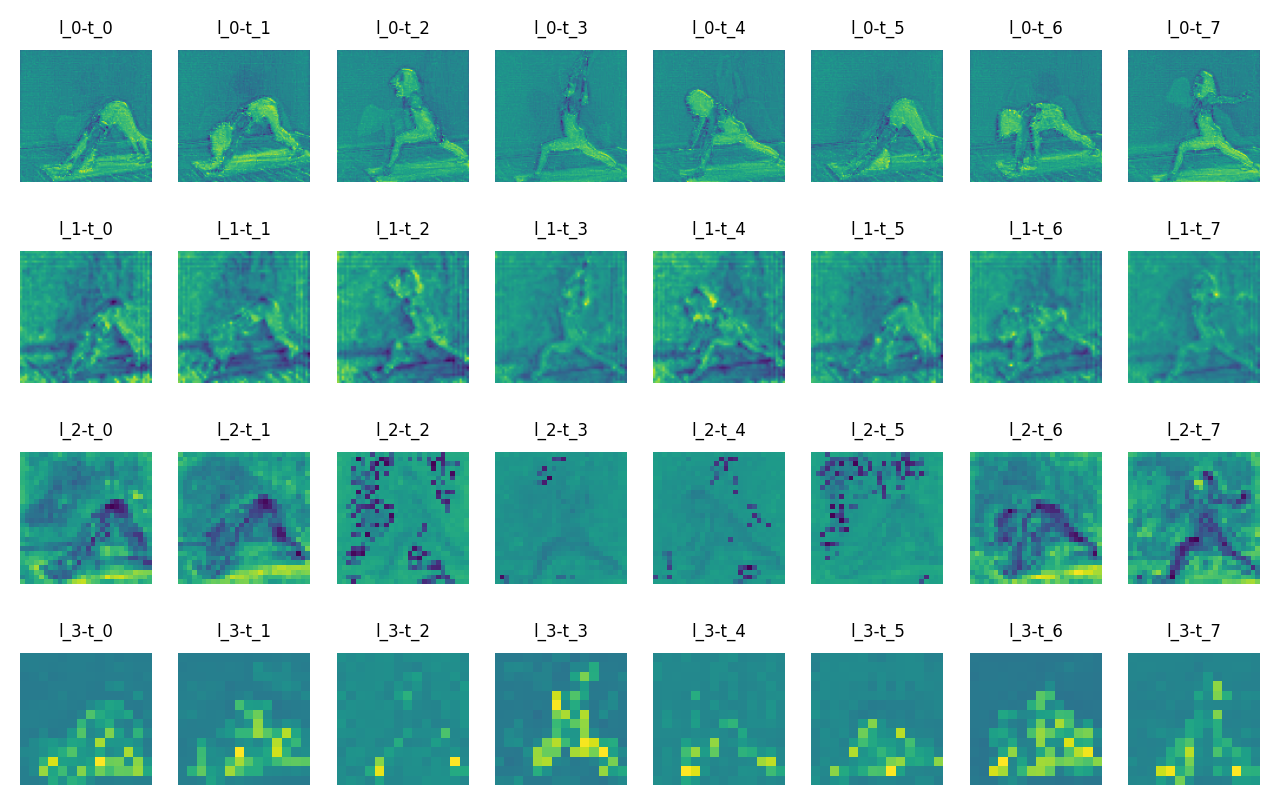

In [16]:
show_fea(19745)